# Getting a handle on the data structure
## Nicholas Bruce | August 13, 2019

I figured this might be useful. You can either run this in a directory that has a `.h5` file, or just read through and hope it makes sense standalone? I've never used Jupyter (this notebook thingy) before so let us see what happens..

Import some useful stuff

In [19]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math

Sort out which file you're going to poke around inside of, and setup a file handle

In [2]:
filename = '1565289740.h5' # you can change this to whatever file you want to open
f = h5py.File(filename, 'r') # read only, because you're following my hacky tutorial and who knows 

Great. Now it acts like a big ol' dictionary. Let's see what's in it by looking at the dictionary keys. These `h5` files will be made up of "groups" and "datasets". They both are accessible using key identifiers. The difference seems to be that groups are organizational, and can contain more groups or datasets, while datasets are full of... data. Let's see what's available.

In [3]:
f.keys()

<KeysViewHDF5 ['detections', 'features', 'freqs', 'merged_detections', 'psd', 'times']>

Neat, we have 6 different objects inside of the file. They're accessible as if they were normal dictionary items. In h5 files you can also have meta data attributes an any dataset

In [4]:
print("File attributes: {}".format(f.attrs.keys()))
print("Detections attributes: {}".format(f['detections'].attrs.keys()))
print("Features attributes: {}".format(f['features'].attrs.keys()))
print("Freqs attributes: {}".format(f['freqs'].attrs.keys()))
print("Merged_detections attributes: {}".format(f['merged_detections'].attrs.keys()))
print("PSD attributes: {}".format(f['psd'].attrs.keys()))
print("Times attributes: {}".format(f['times'].attrs.keys()))

File attributes: <KeysViewHDF5 []>
Detections attributes: <KeysViewHDF5 []>
Features attributes: <KeysViewHDF5 []>
Freqs attributes: <KeysViewHDF5 []>
Merged_detections attributes: <KeysViewHDF5 []>
PSD attributes: <KeysViewHDF5 []>
Times attributes: <KeysViewHDF5 []>


Alright, there was nothing in there. I would say that was a waste of time, but I'm a grad student so apparently I'm made of time. Up next, what type each of the items are.

In [5]:
print("Detections type: {}".format(f['detections'].dtype))
print("Features attributes: {}".format(f['features'].dtype))
print("Freqs attributes: {}".format(f['freqs'].dtype))
print("Merged_detections attributes: {}".format(f['merged_detections'].dtype))
print("PSD attributes: {}".format(f['psd'].dtype))
print("Times attributes: {}".format(f['times'].dtype))

Detections type: float32
Features attributes: float32
Freqs attributes: float32
Merged_detections attributes: float32
PSD attributes: float32
Times attributes: float64


I hope everyone brought their favourite bath toys, because this bad boy is full of floaties.

Now lets take the shape of everything, that should be pretty educational as far as the data structure.

In [6]:
print("Detections shape: {}".format(f['detections'].shape))
print("Features shape: {}".format(f['features'].shape))
print("Freqs shape: {}".format(f['freqs'].shape))
print("Merged_detections shape: {}".format(f['merged_detections'].shape))
print("PSD shape: {}".format(f['psd'].shape))
print("Times shape: {}".format(f['times'].shape))

Detections shape: (4, 398)
Features shape: (6, 301)
Freqs shape: (50000,)
Merged_detections shape: (4, 301)
PSD shape: (50000, 1200)
Times shape: (1200,)


Okay everyone, what have we learned. We have 50000 frequencies and 1200 times, let's expand.

In [7]:
freqs = f['freqs'] # my fingers were getting tired with all this typing
times = f['times']
print("Frequencies from {} Hz to {} Hz with {} bins of width {} Hz".format(min(freqs), max(freqs), len(freqs), abs(freqs[0]-freqs[1])))
print("Center frequency: {} Hz".format((max(freqs)-min(freqs))/2 + min(freqs)))
print("Times from {} s to {} s with spacing of {} s".format(min(times), max(times), abs(times[0]-times[1])))

Frequencies from 435000000.0 Hz to 484999008.0 Hz with 50000 bins of width 992.0 Hz
Center frequency: 459999504.0 Hz
Times from 1565289740.0 s to 1565289859.9 s with spacing of 0.09999990463256836 s


In human time, that means:

In [8]:
print("The data begins at {} and lasts for {} s".format(datetime.datetime.utcfromtimestamp(min(times)), max(times)-min(times)))

The data begins at 2019-08-08 18:42:20 and lasts for 119.90000009536743 s


Okay, we have 2 minutes of data from early August with a 50 MHz bandwidth, centered at 460 MHz. There is a PSD every 0.1 s which corresponds to 10 Hz unless my mental math is failing me horribly.

Using our powers of great observation, we can see that the psd dataset is of shape (50000,1200), so I would wager a hilariously small amount of money that it's a PSD and the axes are frequency vs time...(great work, Watson).

Let's plot it! This is almost definitely going to get my computer up to the temperature of our sun.

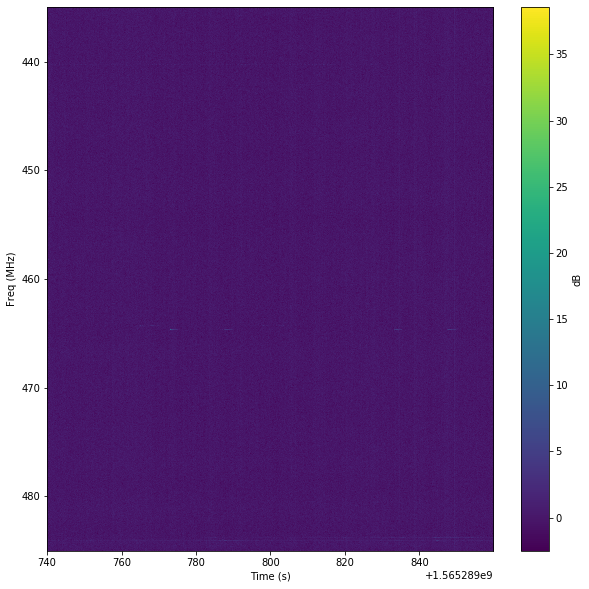

In [9]:
psd = f['psd']
extents = [min(times), max(times), max(freqs)/1e6, min(freqs)/1e6]
fig1, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(10.*np.log10(psd), aspect='auto', extent=extents, interpolation='none')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Freq (MHz)')
cbar = plt.colorbar(im)
cbar.set_label('dB')

Alright, waterfall time! Let's see what's in detections, remembering that the shape of the array is (4, 398). Actually, the powers that be have informed me that detections are box corner coordinates, and some of the boxes overlapped. The powers that be then merged the boxes until there were no overlaps. So lets skip right to 'merged_detections'.


In [13]:
merged_detections = f['detections']
merged_detections[:,0]

array([986.21045, 212.3601 , 990.2676 , 223.46094], dtype=float32)

Alright, this reads like corner coordinates. Hard to tell what's what though, let's see what the dimensional limits are.

In [15]:
for i in range(4):
    print("Max of index {} = {}".format(i, max(merged_detections[i,:])))
    print("Min of index {} = {}".format(i, min(merged_detections[i,:])))


Max of index 0 = 1170.2391357421875
Min of index 0 = -2.1327874660491943
Max of index 1 = 49601.24609375
Min of index 1 = 212.360107421875
Max of index 2 = 1193.6400146484375
Min of index 2 = 22.187658309936523
Max of index 3 = 49613.9296875
Min of index 3 = 223.4609375


Alright, 0 is min time, 2 is max time, 1 is min freq, 3 is max freq. So the corners thing adds up.

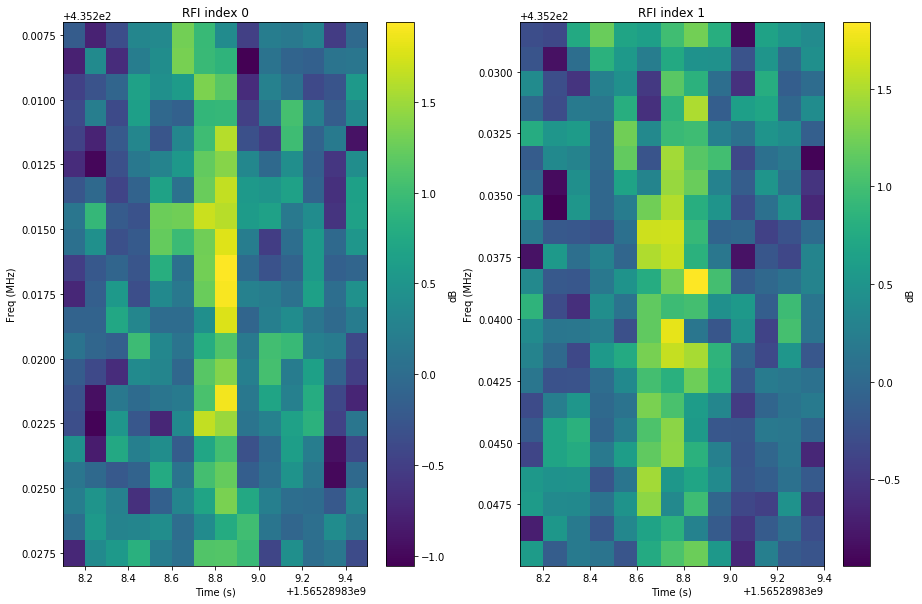

In [35]:
num_to_plot = 2
margin = 5
fig, ax = plt.subplots(1, 2, figsize=(15,10))
for i in range(num_to_plot):
    x1, y1, x2, y2 = np.round(merged_detections[:,i])
#     print("y1: {}, y2: {}, x1: {}, x2: {}".format(y1, y2, x1, x2))

    x1 = int(np.clip(x1-margin, 0, times.shape[0]-1))
    x2 = int(np.clip(x2+margin, 0, times.shape[0]-1))
    y1 = int(np.clip(y1-margin, 0, times.shape[0]-1))
    y2 = int(np.clip(y2+margin, 0, times.shape[0]-1))
#     print("y1: {}, y2: {}, x1: {}, x2: {}".format(y1, y2, x1, x2))

    t1 = times[x1]
    t2 = times[x2]
    f1 = freqs[y1]
    f2 = freqs[y2]
#     print("f1: {}, f2: {}, t1: {}, t2: {}".format(f1,f2,t1,t2))

    extents = [t1, t2, f2/1e6, f1/1e6]
    t1 = math.floor(t1)
    t2 = math.ceil(t2)
    f1 = math.floor(f1)
    f2 = math.ceil(f2)
#     print("f1: {}, f2: {}, t1: {}, t2: {}".format(f1,f2,t1,t2))
    
    rfi = 10.*np.log10(psd[y1:y2,x1:x2])
    im = ax[i].imshow(rfi, extent=extents, aspect='auto', interpolation='none')
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Freq (MHz)')
    fig.colorbar(im, label='dB', ax=ax[i], orientation='vertical')
    ax[i].set_title('RFI index {}'.format(i))

Great, check out that RFI! Let's see what the features of them are meant to be.

In [36]:
features = f['features'] # Note that whenever I do this, I load the array into memory.
                         # If instead I chose to just keep writing f['features']
                         # it would always read the data from disk
features[:,0]

array([4.8460758e+08, 1.2582125e+04, 2.8367301e-02, 1.6431145e-02,
       4.1689453e-01, 3.3003948e+01], dtype=float32)

The powers that be tell me that this is freq, bandwidth, c42, c63, transmission time, received power.

In [38]:
for i in range (num_to_plot):
    print("RFI index {}".format(i))
    print("--| Frequency: {} Hz".format(features[0,i]))
    print("--| Bandwidth: {} Hz".format(features[1,i]))
    print("--| c42: {}".format(features[2,i]))
    print("--| c63: {}".format(features[3,i]))
    print("--| Transmission time: {} s".format(features[4,i]))
    print("--| Received power: {} dB".format(features[5,i]))

RFI index 0
--| Frequency: 484607584.0 Hz
--| Bandwidth: 12582.125 Hz
--| c42: 0.02836730144917965
--| c63: 0.01643114537000656
--| Transmission time: 0.4168945252895355 s
--| Received power: 33.00394821166992 dB
RFI index 1
--| Frequency: 484584224.0 Hz
--| Bandwidth: 9703.0 Hz
--| c42: 0.03325474634766579
--| c63: -0.09485644847154617
--| Transmission time: 0.38410645723342896 s
--| Received power: 30.077444076538086 dB
